<a href="https://colab.research.google.com/github/Atit-Bashyal/solar/blob/main/Solar_dataset_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import math
import csv
from datetime import datetime
from datetime import timedelta
import time
import datetime 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf

from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure

import xlrd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime
from keras.callbacks import EarlyStopping
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [3]:
Kenn = pd.read_csv('/content/drive/MyDrive/Solar_cells/Kenn.csv',parse_dates=[0],index_col=0)
mehring_4 = pd.read_csv('/content/drive/MyDrive/Solar_cells/Mehring IV.csv',parse_dates=[0],index_col=0)
mehring_3 = pd.read_csv('/content/drive/MyDrive/Solar_cells/MehringIII.csv',parse_dates=[0],index_col=0)

In [6]:
Kenn
Kenn = Kenn[['power','global_radiation','temperature']]
Kenn = Kenn.reset_index()
Kenn['t'] = (Kenn['datetime'] - Kenn['datetime'].min()) / (Kenn['datetime'].max() - Kenn['datetime'].min())

Kenn

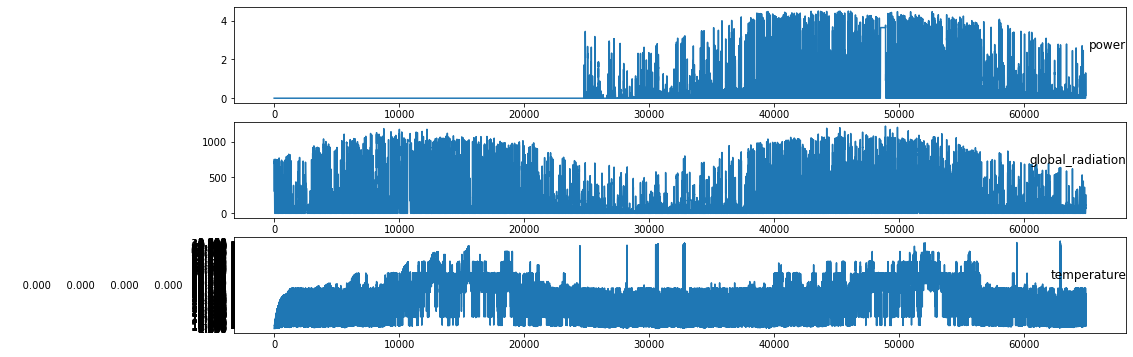

In [9]:
values = Kenn.values
# specify columns to plot
groups = [1, 2,3]
i = 1
# plot each column
plt.figure(figsize=(16, 6))
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(Kenn.columns[group], y=0.5, loc='right')
  i += 1
plt.show()

In [10]:

mehring_4 = mehring_4[['power','global_radiation','temperature']]
mehring_4 = mehring_4.reset_index()
mehring_4['t'] = (mehring_4['datetime'] - mehring_4['datetime'].min()) / (mehring_4['datetime'].max() - mehring_4['datetime'].min())

mehring_4

,datetime,power,global_radiation,temperature,t
0,2019-02-14 09:15:00,370.360,312.310,1.250,0.000000
1,2019-02-14 09:30:00,425.358,363.451,1.950,0.000015
2,2019-02-14 09:45:00,499.826,419.662,1.800,0.000031
3,2019-02-14 10:00:00,569.013,464.191,1.750,0.000046
4,2019-02-14 10:15:00,644.513,509.709,2.400,0.000062
...,...,...,...,...,...
64952,2020-12-21 13:15:00,118.564,113.213,12.600,0.999938
64953,2020-12-21 13:30:00,107.908,100.603,12.450,0.999954
64954,2020-12-21 13:45:00,95.627,68.183,12.500,0.999969
64955,2020-12-21 14:00:00,103.846,99.403,12.600,0.999985


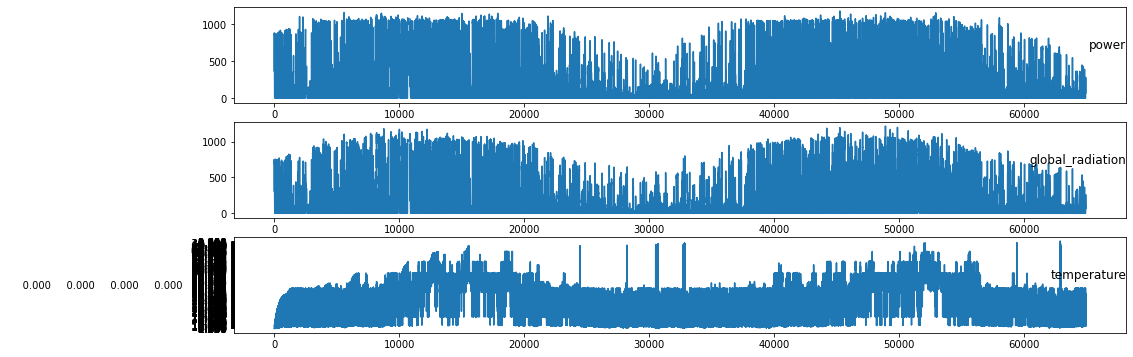

In [11]:
values = mehring_4.values
# specify columns to plot
groups = [1, 2,3]
i = 1
# plot each column
plt.figure(figsize=(16, 6))
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(mehring_4.columns[group], y=0.5, loc='right')
  i += 1
plt.show()

In [14]:
import time
from datetime import datetime
import calendar
mehring_4['Month'] = [x.month for x in mehring_4['datetime']]

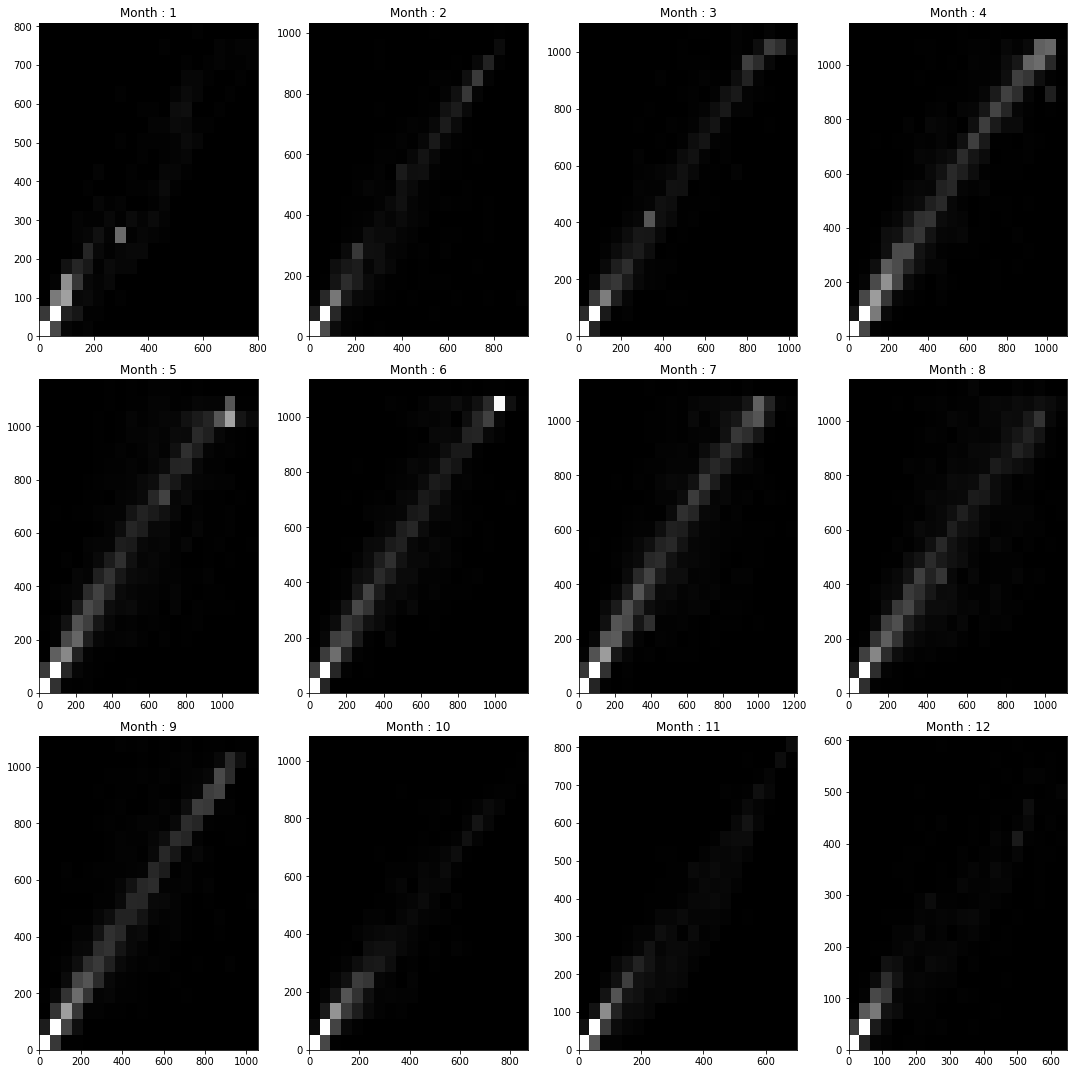

In [30]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()
month_idx = le.fit_transform(mehring_4['Month'])
month = le.classes_

fig, axs = plt.subplots(3,4, figsize=(15, 15))
axs = axs.ravel()


for i, j, p in zip([0,1,2,3,4,5,6,7,8,9,10,11], [0,1,2,3,4,5,6,7,8,9,10,11], month):
    
    axs[j].set_ylabel("")
    axs[j].set_xlabel('')
    
    axs[j].set_title('Month : %s' % p)
    axs[j].hist2d(mehring_4[mehring_4['Month']==p]['global_radiation'],\
                mehring_4[mehring_4['Month']==p]['power'],bins=20,cmap = plt.cm.binary.reversed(),cmax=2000)
plt.tight_layout(True);

In [34]:
NN_df = mehring_4[['datetime', 'global_radiation','power']].set_index('datetime')

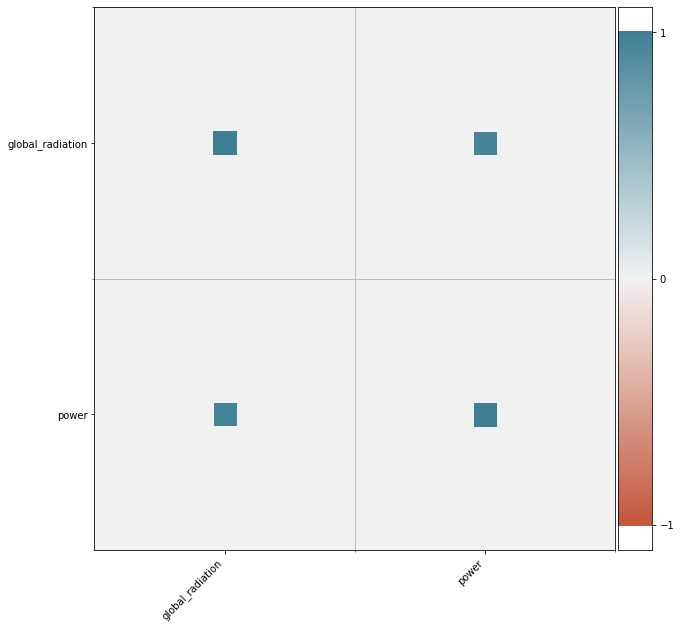

In [35]:
corr = NN_df.corr()
plt.figure(figsize=(10, 10))
corrplot(corr)

In [36]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(NN_df)

In [39]:
features =  data_scaled
target = data_scaled[:,-1]


In [43]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size = 0.50, random_state=123,shuffle = False)

In [47]:
from keras.preprocessing.sequence import TimeseriesGenerator

win_length = 18*4 #18 hrs, 4 as data is in 15 mins
batch_size = 10 
n_features = 2

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, batch_size=batch_size) 
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, batch_size=batch_size) 

In [48]:
from keras.layers import LeakyReLU
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(128, return_sequences=True ,input_shape=(win_length, n_features)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False ,input_shape=(win_length, n_features)))
model.add(Dense(256))
model.add(Dense(1))

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
history =model.fit_generator(train_generator,epochs = 3,validation_data=test_generator,shuffle=False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
3241/3241 [==============================] - 328s 100ms/step - loss: 0.0156 - val_loss: 0.0072
Epoch 2/3
3241/3241 [==============================] - 329s 102ms/step - loss: 0.0104 - val_loss: 0.0076
Epoch 3/3
3241/3241 [==============================] - 325s 100ms/step - loss: 0.0097 - val_loss: 0.0079


In [50]:
model.evaluate(test_generator)

3241/3241 [==============================] - 65s 20ms/step - loss: 0.0079


0.00785487238317728

In [51]:
predictions = model.predict(test_generator)

In [52]:
df_pred = pd.concat([pd.DataFrame(x_test[:,1:][win_length:]),pd.DataFrame(predictions)],axis=1)

In [53]:
rev_trans = scaler.inverse_transform(df_pred)

In [54]:
df_final =NN_df[predictions.shape[0]*-1:]

In [55]:
df_final['pred_power'] = rev_trans[:,-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


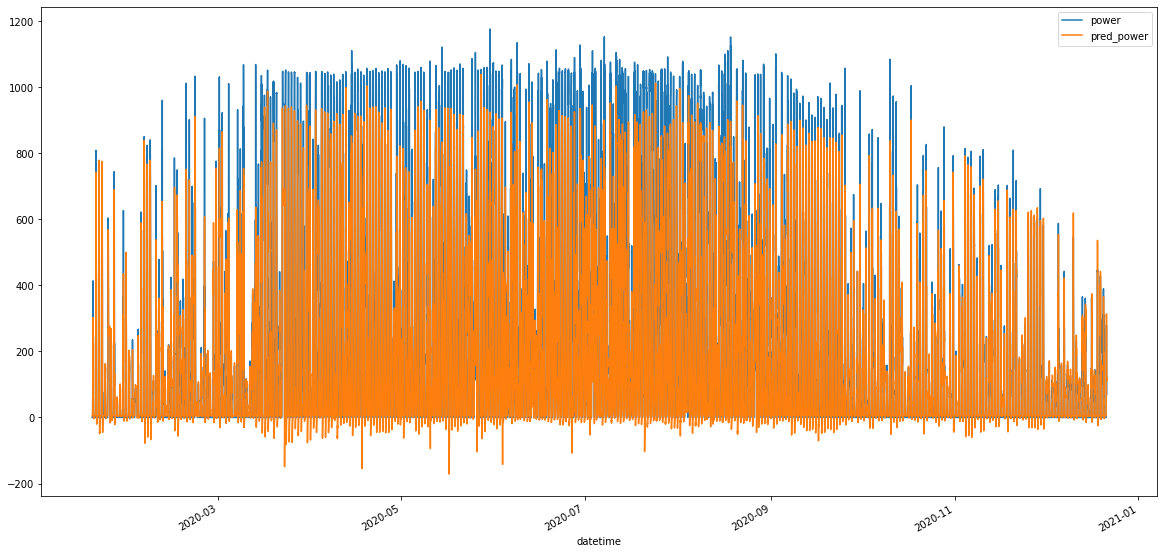

In [56]:
df_final[['power','pred_power']].plot(figsize=(20,10))